In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import cv2
from matplotlib import pyplot as plt
import numpy as np

from numpy.lib.stride_tricks import as_strided

from utils import load_image, toGrey, index_row_in_array, is_row_in_array, imshow_components
from collections import defaultdict

In [3]:
def getKernels(img, kernel_size):
    kx, ky = (kernel_size, kernel_size) if type(kernel_size) == int else kernel_size
    sx, sy = img.shape
    s1, s2 = img.strides
    
    return as_strided(
        img,
        shape=(
            sx - kx+1,
            sy - ky+1,
            kx,
            ky
        ),
        strides=(
            s1,
            s2,
            s1,
            s2
        ),
        writeable=False,
    )

In [334]:
def discoverSegments(image, kernel_size=7):
    kernels = getKernels(image, kernel_size)
    
    start_classes_discovered = []
    classes_discovered = defaultdict(list)

    # kernels along the horizntal
    for kernelx in kernels:
        #kernels along the vertical
        for kernel in kernelx:

            #the pixels in kernel
            kernel_pixels = kernel.flatten()

            #the starting pixel
            pixel = kernel_pixels.min()

            #distribution of kernel pixels
            distr = kernel_pixels
            
            #the barrier to cross
            threshold = (distr.mean() + (distr.min() / 2))
            
            #outlier detection
            outlier_check = kernel_pixels > threshold

            #if outlier not present, high end class
            if not outlier_check.any():
                continue
            
            #get the outliers
            high_end = kernel_pixels[outlier_check]

            #add lower class to the classes found
            classes_discovered[pixel].append(kernel_pixels[~outlier_check].max())
            yield pixel, kernel_pixels[~outlier_check].max()
            
            #add to the classes found
            classes_discovered[high_end.min()].append(high_end.max())
            yield high_end.min(), high_end.max()

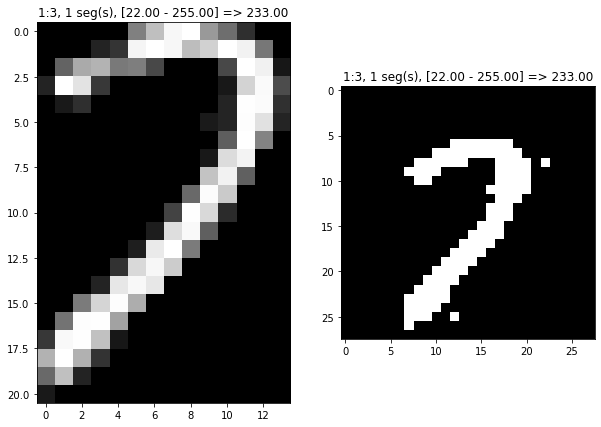

In [337]:
# img_x = getSegments(image_test)
# img_x = getSegments(image_plate, -1, 100)
img_x = getSegments(image2)

In [455]:
def getSegments(image, stop=-1):
    #pick kernel size
    kernel_size = min(image.shape)
    
    # the segments discovered
    num_of_segments = 0
    
    #get the classes
    for low, high in discoverSegments(image, kernel_size):
        # get the ones in range of low-high class discovered
        img = ((image >= low) & (image <= high)).astype(np.int8)
            
        # get the sub segments in image class
        ret, labels = cv2.connectedComponents(img)

        # for each sub segment label
        for label in range(1, ret):
            if image[np.where(labels == label)].std() < 5:
                continue
        
            # get all positions active(i.e equal to 1)
            pos = np.where(labels == label)

            # all activated pos in image label
            ar1, ar2 = pos

            x1, x2 = min(ar1), max(ar1)+1
            y1, y2 = min(ar2), max(ar2)+1
            
            if x2-x1 < 3 and y2-y1 < 3:
                continue
                
            # centroid of segment
            # point = (ar2.mean(), ar1.mean())
            
            # null space as -1 instead of 0 to avoid confusion
            img_objx = np.full(img.shape, -1, dtype=np.int64)
            img_objx[np.where(labels == label)] = image[np.where(labels == label)] #crop segment

            # extract segment
            img_objx = img_objx[x1:x2, y1:y2]

            # x-xsize, y-ysize
            xsize, ysize = img_objx.shape

            # save image in standard memory size
            img_obj = np.full((30, 30), -1, dtype=np.int64)
            img_obj[0:xsize, 0:ysize] = img_objx #save in memory standard image
            
            #update the num of segments
            num_of_segments += 1
            
            yield img_obj
            if num_of_segments == stop: break
        if num_of_segments == stop: break


#             li = [0, img_objx, img]
#             fig=plt.figure(figsize=(10, 10))
#             for k in range(1, 3):
#                 ax = fig.add_subplot(1, 2, k)
#                 ax.set_title(f'{label}:{ret-1}, {num_of_segments} seg(s), [{low:.2f} - {high:.2f}] => {high-low:.2f}')

#                 if k == 2:
#                     plt.imshow(li[k], cmap='gray', vmin=0, vmax=1)

#                 if k == 1:
#                     plt.imshow(li[k], cmap='gray', vmin=0, vmax=255)

#             plt.show()
#             if num_of_segments == stop: return img_objx

In [456]:
def compare(img_11, img_22):
    # get the actual image embedded in negative space
    def getSubImage(img):
        pos = np.where(img != -1)
        ar1, ar2 = pos

        x1, x2 = min(ar1), max(ar1)+1
        y1, y2 = min(ar2), max(ar2)+1

        return img[x1:x2, y1:y2].copy()

    # get the sub image of images
    img_1 = getSubImage(img_11)
    img_2 = getSubImage(img_22)
    
#     plt.imshow(img_1, cmap='gray', vmin=0, vmax=255)
#     print(img_1.shape)
#     plt.show()
    
#     plt.imshow(img_2, cmap='gray', vmin=0, vmax=255)
#     print(img_2.shape)
#     plt.show()

    # get the shape of the images
    c11, c12 = img_1.shape
    c21, c22 = img_2.shape

    # get the min of the x and size
    r = c21 if c21 < c11 else c11
    c = c22 if c22 < c12 else c12
    
    # base area of image (scaled down vrsion)
    base_area = r * c

    # size ratio (quantifies reduction/loss of data)
    sr1 = base_area / (img_1.shape[0] * img_1.shape[1])
    sr2 = base_area / (img_2.shape[0] * img_2.shape[1])

    # the trust factor for scaling down (consequence of scaling down)
    scale_weight = sr1*sr2
    
    img1_before_before = img_1.copy()
    img2_before_before = img_2.copy()

    # the place holder pixel, using 255 - x cos of background and foreground can blend
    r1 = 255 - img_1[img_1 != -1].mean()
    img_r1 = None if r1 in img_1 else r1

    r2 = 255 - img_2[img_2 != -1].mean()
    img_r2 = None if r2 in img_2 else r2

    # remove -1 cos of interpolation
    if img_r1 is not None:
        img_1[img_1 == -1] = img_r1

    if img_r2 is not None:
        img_2[img_2 == -1] = img_r2

    # resize images (scale it down to minimum)
    img_1 = cv2.resize(img_1.astype(np.uint8), (c, r), interpolation=cv2.INTER_AREA).astype(np.float64)
    img_2 = cv2.resize(img_2.astype(np.uint8), (c, r), interpolation=cv2.INTER_AREA).astype(np.float64)

    img1_before = img_1.copy()
    img2_before = img_2.copy()

    # put back -1 after interpolation
    if img_r1 is not None:
        img_1[img_1 == int(img_r1)] = -1

    if img_r2 is not None:
        img_2[img_2 == int(img_r2)] = -1

    # find the centroid of image 1 and 2
    img_1a, img_1b = np.where(img_1 != -1)
    try:
        img_1a, img_1b = int(img_1a.mean()), int(img_1b.mean())

    except:
        print(img_r1, r1)
        print(img1_before_before)
        print(img1_before)
        print(img_1)
        return 0

    img_2a, img_2b = np.where(img_2 != -1)
    try:
        img_2a, img_2b = int(img_2a.mean()), int(img_2b.mean())

    except:
        print(img_r2, r2)
        print(img2_before_before)
        print(img2_before)
        print(img_2)
        return 0
    
#     plt.imshow(img_1, cmap='gray', vmin=0, vmax=255)
#     print(img_1.shape)
#     plt.show()
    
#     plt.imshow(img_2, cmap='gray', vmin=0, vmax=255)
#     print(img_2.shape)
#     plt.show()
    
    d, f = img_1.shape
    g, h = img_2.shape

    if img_1a <= img_2a:
        img_1x1 = img_2a - img_1a
        img_1x2 = img_1x1 + d

        img_2x1, img_2x2 = 0, g

    else:
        img_2x1 = img_1a - img_2a
        img_2x2 = img_2x1 + g

        img_1x1, img_1x2 = 0, d


    if img_1b <= img_2b:
        img_1y1 = img_2b - img_1b
        img_1y2 = img_1y1 + f

        img_2y1, img_2y2 = 0, h

    else:
        img_2y1 = img_1b - img_2b
        img_2y2 = img_2y1 + h

        img_1y1, img_1y2 = 0, f

    r = max((img_1x2, img_2x2))
    c = max((img_1y2, img_2y2))

    # the new images
    img_n1, img_n2 = np.full((r, c), -1, dtype=np.int64), np.full((r, c), -1, np.int64)

    # the new images
    img_n1[img_1x1:img_1x2, img_1y1:img_1y2] = img_1
    img_n2[img_2x1:img_2x2, img_2y1:img_2y2] = img_2

    img_b = img_n1.copy()
    img_b[img_n2 == -1] = -1

    m = 255 if np.amax(img_n1) > 1 or np.amax(img_n2) > 1 else 1
    m = 255

    img_n1[img_n1 == -1] = 255 - img_n2[img_n2 != -1].mean()
    img_b[img_b == -1] = 255 - img_n2[img_n2 != -1].mean()
    img_n2[img_n2 == -1] = 255 - img_n1[img_n1 != -1].mean()

    z1 = (m - abs(img_b - img_n2).mean()) / m
    z2 = (m - abs(img_b - img_n1).mean()) / m
    z3 = (m - abs(img_n2 - img_n1).mean()) / m
    
    z = scale_weight * (z1 + z2 + z3) / 3
    
#     delta = abs(img_n2 - img_n1)
    
#     delta1 = delta.copy()
#     delta1[img_n1 == -1] = 255
#     z1 = (255 - delta1.mean()) / 255
    
#     delta2 = delta.copy()
#     delta2[img_n2 == -1] = 255
#     z2 = (255 - delta2.mean()) / 255
    
#     delta3 = delta.copy()
#     delta3[img_n1 == -1] = 255
#     delta3[img_n2 == -1] = 255
#     z3 = (255 - delta3.mean()) / 255
    
#     z = scale_weight * z1 * z2 * z3
#     z = scale_weight * ((.25 * z1) + (.25 * z2) + (.5 * z3))

#     li = [None, img1_before_before, img2_before_before]
#     fig=plt.figure(figsize=(10, 10))
#     for k in range(1, 3):
#         ax = fig.add_subplot(1, 2, k)
#         ax.set_title(f'similarity {z:.4f}')

#         plt.imshow(li[k], cmap='gray', vmin=0, vmax=255)

#     plt.show()
    
    return z1, z2, z3, z

In [627]:
def compare(img_11, img_22):
    def centralize(img_coordinates):
        return np.array([row - row.mean() for row in img_coordinates], dtype=np.float64)

    # get the actual image embedded in negative space
    def getSubImage(img):
        pos = np.where(img != -1)
        ar1, ar2 = pos

        x1, x2 = min(ar1), max(ar1)+1
        y1, y2 = min(ar2), max(ar2)+1

        return img[x1:x2, y1:y2].copy()

    # get the sub image of images
    img_1 = getSubImage(img_11)
    img_2 = getSubImage(img_22)

    # get the shape of the images
    c11, c12 = img_1.shape
    c21, c22 = img_2.shape

    # get the min of the x and size
    r = c21 if c21 < c11 else c11
    c = c22 if c22 < c12 else c12
    
    # base area of image (scaled down vrsion)
    base_area = len(np.where(img_1 != -1)[0]) * len(np.where(img_2 != -1)[0])
    
    img1_before_before = img_1.copy()
    img2_before_before = img_2.copy()

    # the place holder pixel, using 255 - x cos of background and foreground can blend
    r1 = 255 - img_1[img_1 != -1].mean()
    img_r1 = None if r1 in img_1 else r1

    r2 = 255 - img_2[img_2 != -1].mean()
    img_r2 = None if r2 in img_2 else r2

    # remove -1 cos of interpolation
    if img_r1 is not None:
        img_1[img_1 == -1] = img_r1

    if img_r2 is not None:
        img_2[img_2 == -1] = img_r2

    # resize images (scale it down to minimum)
    img_1 = cv2.resize(img_1.astype(np.uint8), (c, r), interpolation=cv2.INTER_AREA).astype(np.float64)
    img_2 = cv2.resize(img_2.astype(np.uint8), (c, r), interpolation=cv2.INTER_AREA).astype(np.float64)

    img1_before = img_1.copy()
    img2_before = img_2.copy()

    # put back -1 after interpolation
    if img_r1 is not None:
        img_1[img_1 == int(img_r1)] = -1

    if img_r2 is not None:
        img_2[img_2 == int(img_r2)] = -1
    
    # size ratio (quantifies reduction/loss of data)
    scale_weight = 1 - (abs(base_area - (len(np.where(img_1 != -1)[0]) * len(np.where(img_2 != -1)[0]))) / base_area)
    
    # find the coordinates of image 1 and 2 with center as centroid
    image_1_coordinates = np.array(np.where(img_1 != -1)).T
    image_2_coordinates = np.array(np.where(img_2 != -1)).T
    
    coord1, coord2 = (centralize(image_1_coordinates), centralize(image_2_coordinates))
    
    if len(image_1_coordinates) > len(image_2_coordinates):
        coord1, coord2 = coord2, coord1
        image_1_coordinates, image_2_coordinates = image_2_coordinates, image_1_coordinates\
        
    error1, error2, error3 = [], [], []
    MAX = 28
    
    for index, coord in enumerate(coord1):
        
        #position difference
        diff = abs(coord - coord2).sum(1)
        
        #pixel difference
        x1, y1 = image_1_coordinates[index]
        x2, y2 = image_2_coordinates[diff.argmin()]
        color_dev = abs(img_1[x1, y1] - img_2[x2, y2]) / 255
        
        #the diff in position (and pixel)
        coord2[diff.argmin()] = MAX**2
        position_dev = diff.min() / MAX
        
        #teh error from position and color
        error1.append((color_dev + position_dev) / 2)
    
    unmatched = coord2[coord2 < MAX**2]
    
    error1 = np.array(error1).mean()
    error2 = ((abs(unmatched / MAX) + 1) / 2).mean() if len(unmatched) else 0
    
    error = (error1 + error2) / 2
    similarity = scale_weight * (1 - error)
    
#     li = [None, img_1, img_2]
#     li = [None, img1_before_before, img2_before_before]
#     fig=plt.figure(figsize=(10, 10))
#     for k in range(1, 3):
#         ax = fig.add_subplot(1, 2, k)
#         ax.set_title(f'similarity {similarity:.4f}')

#         plt.imshow(li[k], cmap='gray', vmin=0, vmax=255)

#     plt.show()
    
    return f"sim: {similarity:.4f}, error => {error1:.4f} {error2:.4f}: {error:.4f}, scale = {scale_weight:.4f}"

In [628]:
j = 4
img_x = list(getSegments(image4))

for x in img_x:
    for i, imagex in enumerate([image1, image2, image3, image4, image5, image6]):
        img_y = list(getSegments(imagex))
        for y in img_y:
            print(f"{nums[j-1]} <==> {nums[i]} = {compare(x, y)}")
        print()


1 <==> 9 = sim: 0.4801, error => 0.2947 0.5929: 0.4438, scale = 0.8632
1 <==> 9 = sim: 0.0491, error => 0.0601 0.5089: 0.2845, scale = 0.0686

1 <==> 7 = sim: 0.4736, error => 0.2288 0.5842: 0.4065, scale = 0.7980

1 <==> 9 = sim: 0.1754, error => 0.2581 0.5079: 0.3830, scale = 0.2843
1 <==> 9 = sim: 0.3450, error => 0.2599 0.6125: 0.4362, scale = 0.6119

1 <==> 1 = sim: 1.0000, error => 0.0000 0.0000: 0.0000, scale = 1.0000

1 <==> 1 = sim: 0.5431, error => 0.1203 0.6062: 0.3633, scale = 0.8529

1 <==> 3 = sim: 0.1332, error => 0.3073 0.5665: 0.4369, scale = 0.2365
1 <==> 3 = sim: 0.3161, error => 0.2922 0.6014: 0.4468, scale = 0.5714



In [511]:
nums = [9, 7, 9, 1, 1, 3]

image1 = toGrey(load_image('dump/old_test/img_3.jpg'))
image2 = toGrey(load_image('dump/old_test/img_12.jpg'))
image3 = toGrey(load_image('dump/old_test/9.jpg'))
image4 = toGrey(load_image('dump/old_test/img_229.jpg'))
image5 = toGrey(load_image('dump/old_test/img_217.jpg'))
image6 = toGrey(load_image('dump/old_test/img_215.jpg'))
# image_plate = toGrey(load_image('dump/plate.png'))
image_test = toGrey(load_image('dump/WIN_20190829_16_17_54_Pro.jpg'))

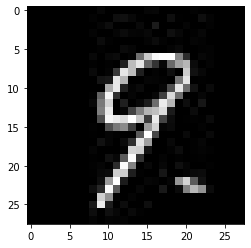

In [168]:
plt.imshow(image1.astype(np.uint8), cmap='gray', vmin=0)

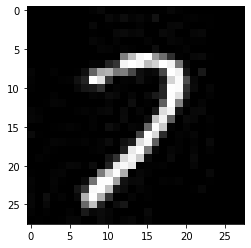

In [169]:
plt.imshow(image2.astype(np.uint8), cmap='gray', vmin=0)

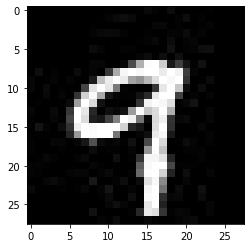

In [170]:
plt.imshow(image3.astype(np.uint8), cmap='gray', vmin=0)

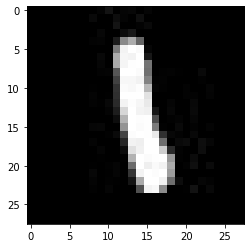

In [171]:
plt.imshow(image4.astype(np.uint8), cmap='gray', vmin=0)

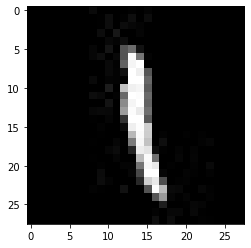

In [172]:
plt.imshow(image5.astype(np.uint8), cmap='gray', vmin=0)

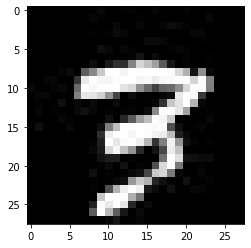

In [173]:
plt.imshow(image6.astype(np.uint8), cmap='gray', vmin=0)

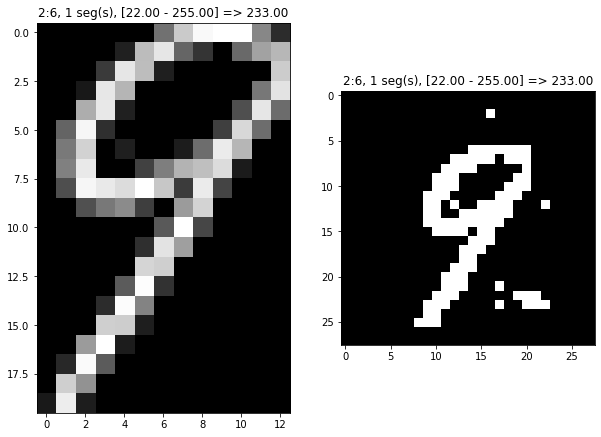

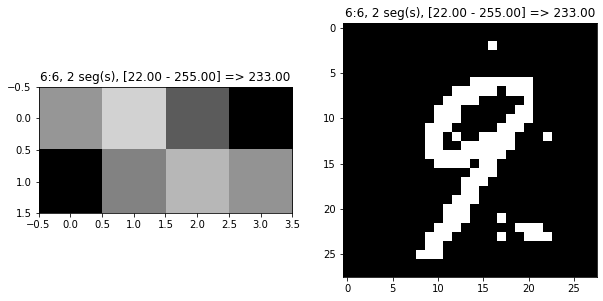

In [347]:
img_1x = getSegments(image1, 20)

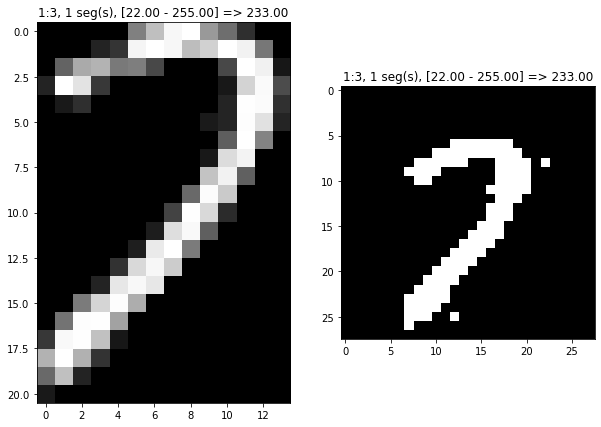

In [339]:
img_2x = getSegments(image2, 34)

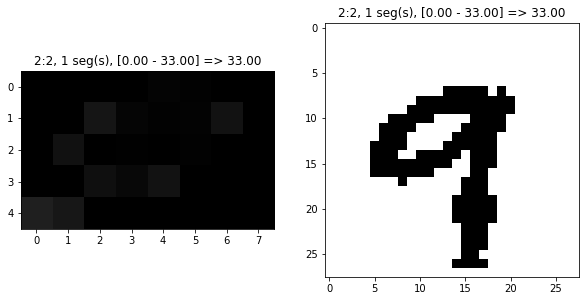

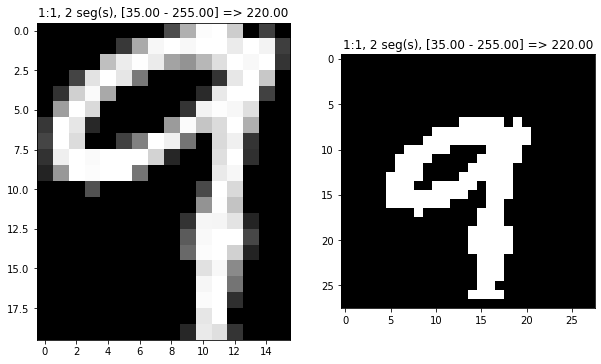

In [340]:
img_3x = getSegments(image3, 49)

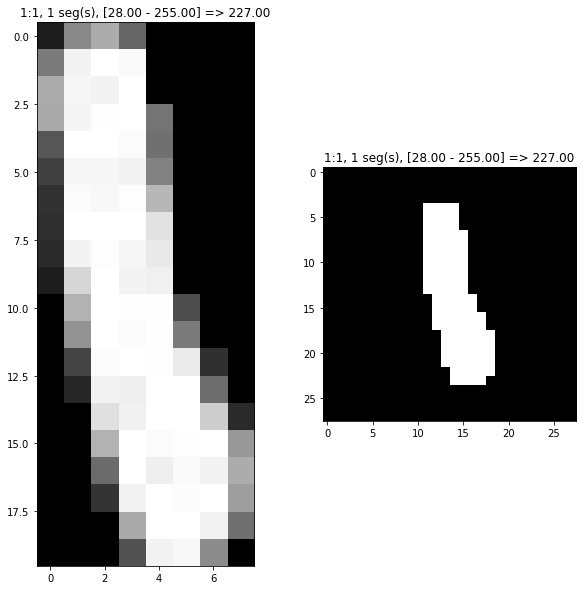

In [341]:
img_4x = getSegments(image4)

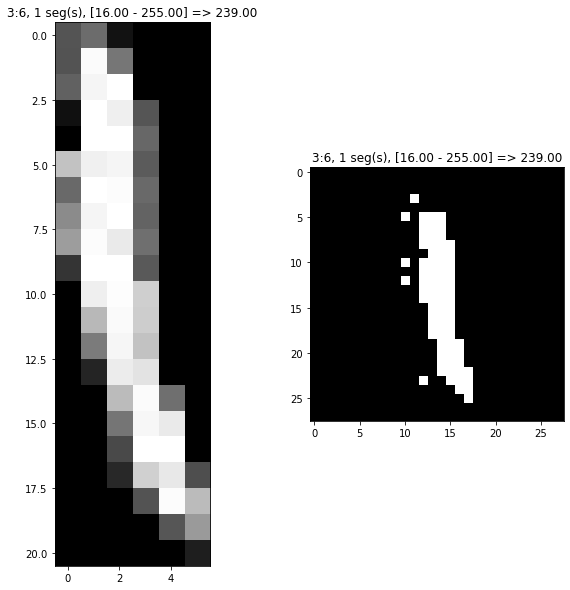

In [342]:
img_5x = getSegments(image5)

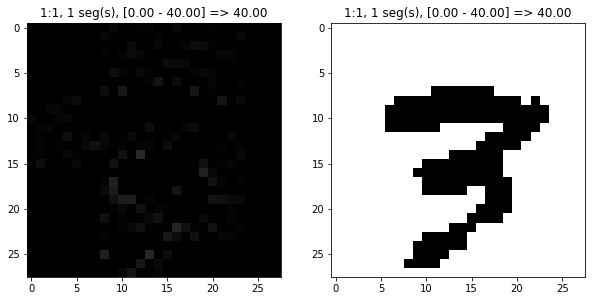

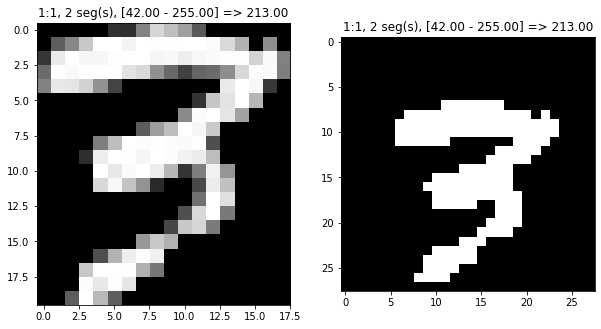

In [343]:
img_6x = getSegments(image6, 42)

In [344]:
img_1x.shape, img_2x.shape, img_3x.shape, img_4x.shape, img_5x.shape, img_6x.shape

AttributeError: 'NoneType' object has no attribute 'shape'

TypeError: Image data of dtype object cannot be converted to float

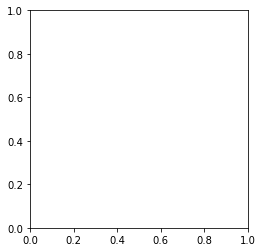

In [345]:
plt.imshow(img_1x, cmap='gray', vmin=0, vmax=255)

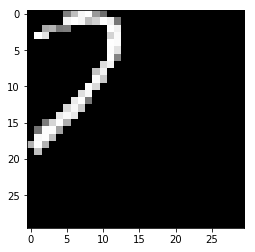

In [204]:
plt.imshow(img_2x, cmap='gray', vmin=0, vmax=255)

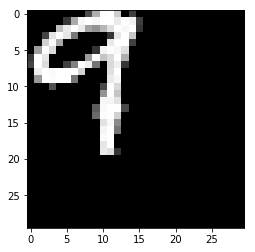

In [205]:
plt.imshow(img_3x, cmap='gray', vmin=0, vmax=255)

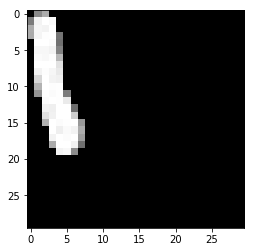

In [206]:
plt.imshow(img_4x, cmap='gray', vmin=0, vmax=255)

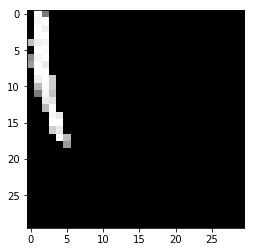

In [207]:
plt.imshow(img_5x, cmap='gray', vmin=0, vmax=255)

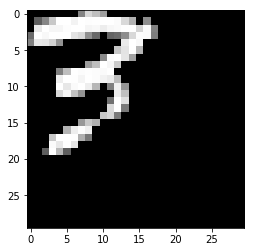

In [208]:
plt.imshow(img_6x, cmap='gray', vmin=0, vmax=255)

In [276]:
similarities = []
for img_1y in [img_1x, img_2x, img_3x, img_4x, img_5x, img_6x]:
    similarities.append(compare(img_1x, img_1y))

0.6261764705882353 1.0 0.6261764705882353 1.0 0.7507843137254903 0.7507843137254903
0.7610859728506788 0.9592185592185593 0.7604682898800547 0.9230769230769231 0.8269242739830975 0.7633147144459361
0.6993837535014006 0.9590616246498599 0.7005462184873951 0.75 0.7863305322128852 0.5897478991596639
0.37844084493700864 0.9427678317703894 0.42968646395756366 0.6666666666666666 0.5836317135549872 0.3890878090366581
0.40748366013071896 0.9095751633986928 0.49124183006535954 0.475 0.6027668845315904 0.2863142701525055
0.638582202111614 0.9482805429864254 0.6480693815987933 0.6666666666666666 0.7449773755656109 0.49665158371040724


In [277]:
for i, similarity in enumerate(similarities):
    print(f"{nums[0]} <==> {nums[i]} = {similarity}")

9 <==> 9 = 0.8753921568627452
9 <==> 7 = 0.8750005985300103
9 <==> 9 = 0.7681652661064426
9 <==> 1 = 0.6251491901108269
9 <==> 1 = 0.5388834422657952
9 <==> 3 = 0.7058220211161388


[[108 108 108 108 108 108 113 202 249 255 255 135  44]
 [108 108 108 108  33 188 230 101  52 108 106 162 183]
 [108 108 108  58 230 189  31 108 108 108 108 108 204]
 [108 108  24 231 181 108 108 108 108 108 108 119 228]
 [108 108 173 232  32 108 108 108 108 108  79 230 108]
 [108 100 246  47 108 108 108 108 108  63 216 109 108]
 [108 122 210 108  31 108 108  28 109 235 182 108 108]
 [108 128 233 108 108  66 126 180 191 220  27 108 108]
 [108  78 246 233 220 255 199  59 235  68 108 108 108]
 [108 108  80 120 139  62 108 155 211 108 108 108 108]
 [108 108 108 108 108 108  90 255  70 108 108 108 108]
 [108 108 108 108 108  47 227 159 108 108 108 108 108]
 [108 108 108 108 108 213 207 108 108 108 108 108 108]
 [108 108 108 108  91 253  50 108 108 108 108 108 108]
 [108 108 108  45 252 131 108 108 108 108 108 108 108]
 [108 108 108 207 205  30 108 108 108 108 108 108 108]
 [108 108 155 255  28 108 108 108 108 108 108 108 108]
 [108  40 250  91 108 108 108 108 108 108 108 108 108]
 [108 207 